In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('train.csv')
df.head()

,boundary,construction,dimensions,fig_count,floor,location,open_sides,price,price_per_sqft,transaction,type,garden_park,main_road,pool,width_road,area
0,Yes,Yes,45 X 32,10,5,Rajarhat,2.0,23.0,1597,New Property,Residential Land / Plot,1,1,0,30.0,1440
1,Yes,Yes,60 X 60,5,4,Action Area 3,1.0,60.5,1681,New Property,Residential Land / Plot,1,1,0,8.0,3600
2,No,No,NaN,19,NaN,Joka,2.0,1.4,194,New Property,Residential Land / Plot,0,1,0,25.0,720
3,Yes,No,49.2 X 32.8,2,4,Action Area 3,1.0,90.0,5574,Resale,Residential Land / Plot,0,1,0,13.0,1615
4,No,No,42 X 40,5,Congo,Badu,4.0,9.5,565,Resale,Residential Land / Plot,1,1,0,3.0,1680


# Initial One-Hot Encoding

In [3]:
def convert_yes_to_1(x) :
    return 1 if x == 'Yes' else 0

df['construction'] = df['construction'].apply(convert_yes_to_1)

df['boundary'] = df['boundary'].apply(convert_yes_to_1)

df['new_property'] = df['transaction'].apply(lambda x : 1 if x == 'New Property' else 0)

In [4]:
df['new_property'].value_counts()

new_property
0    701
1    321
Name: count, dtype: int64

In [5]:
df = df.drop(['dimensions', 'type', 'transaction', 'price', 'fig_count'], axis=1)

df.shape

(1022, 12)

# Data Manipulation

In [6]:
df.head()

,boundary,construction,floor,location,open_sides,price_per_sqft,garden_park,main_road,pool,width_road,area,new_property
0,1,1,5,Rajarhat,2.0,1597,1,1,0,30.0,1440,1
1,1,1,4,Action Area 3,1.0,1681,1,1,0,8.0,3600,1
2,0,0,NaN,Joka,2.0,194,0,1,0,25.0,720,1
3,1,0,4,Action Area 3,1.0,5574,0,1,0,13.0,1615,0
4,0,0,Congo,Badu,4.0,565,1,1,0,3.0,1680,0


In [7]:
df.describe()

,boundary,construction,open_sides,price_per_sqft,garden_park,main_road,pool,width_road,area,new_property
count,1022.000000,1022.000000,734.000000,1022.000000,1022.000000,1022.000000,1022.000000,734.000000,1022.000000,1022.00000
mean,0.521526,0.341487,6.062670,1431.720157,0.261252,0.382583,0.003914,31.441417,5977.372798,0.31409
std,0.499781,0.474441,110.662972,1145.857797,0.439532,0.486256,0.062469,356.185113,18983.070738,0.46438
min,0.000000,0.000000,1.000000,77.000000,0.000000,0.000000,0.000000,1.000000,100.000000,0.00000
25%,0.000000,0.000000,1.000000,530.750000,0.000000,0.000000,0.000000,7.000000,1440.000000,0.00000
50%,1.000000,0.000000,2.000000,1200.000000,0.000000,0.000000,0.000000,10.000000,1942.500000,0.00000
75%,1.000000,1.000000,2.000000,1908.000000,1.000000,1.000000,0.000000,15.750000,3600.000000,1.00000
max,1.000000,1.000000,3000.000000,5864.000000,1.000000,1.000000,1.000000,9144.000000,288000.000000,1.00000


## Floors

In [8]:
df.loc[df['floor'] == 'Congo', 'floor'] = np.nan
df['floor'] = pd.to_numeric(df['floor'], errors='coerce')
df['floor'] = df['floor'].fillna(df['floor'].median())

print(df['floor'].value_counts(dropna=False))

floor
3.0     591
4.0     170
5.0      94
1.0      83
2.0      52
6.0      17
20.0      4
10.0      4
15.0      2
7.0       2
12.0      1
18.0      1
8.0       1
Name: count, dtype: int64


## Open Sides and Width Roads

In [9]:
median_main_road_width = df[df['main_road'] == 1]['width_road'].median()
median_main_road_open = df[df['main_road'] == 1]['open_sides'].median()

df['width_road'] = df['width_road'].fillna(0)
df['open_sides'] = df['open_sides'].fillna(0)

df.loc[(df['main_road'] == 1) & (df['width_road'] == 0), 'width_road'] = median_main_road_width
df.loc[(df['main_road'] == 1) & (df['open_sides'] == 0), 'open_sides'] = median_main_road_open

df = df[df['width_road']<=40]
df = df[df['width_road']>0]

df.shape  

(735, 12)

In [10]:
df['width_open'] = df['width_road'] * df['open_sides']

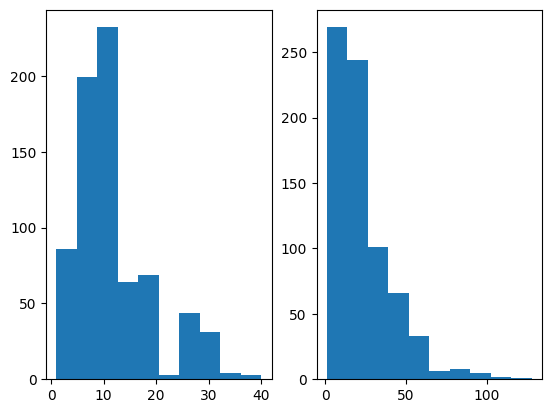

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.hist(df['width_road'], bins=10)
ax2.hist(df['width_open'], bins=10)
plt.show()

## Area

In [12]:
df = df[df['area'] <= 50000]

df.shape

(726, 13)

## Adding Features

In [13]:
## Adding Features

df['floor_by_area'] = df['floor'] * 100 / df['area']
df['floor_by_width'] = df['floor'] / df['width_road']

# Normalization

In [14]:
df.describe()

,boundary,construction,floor,open_sides,price_per_sqft,garden_park,main_road,pool,width_road,area,new_property,width_open,floor_by_area,floor_by_width
count,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000
mean,0.506887,0.392562,3.315427,1.961433,1374.998623,0.356749,0.517906,0.002755,11.617080,3426.041322,0.420110,22.382920,0.202670,0.419054
std,0.500297,0.488657,1.511687,0.914949,1195.682081,0.479370,0.500024,0.052450,7.461307,5698.059865,0.493917,17.710295,0.170769,0.358818
min,0.000000,0.000000,1.000000,1.000000,77.000000,0.000000,0.000000,0.000000,1.000000,100.000000,0.000000,1.000000,0.002449,0.025000
25%,0.000000,0.000000,3.000000,1.000000,417.000000,0.000000,0.000000,0.000000,7.000000,1440.000000,0.000000,10.000000,0.111111,0.200000
50%,1.000000,0.000000,3.000000,2.000000,1098.500000,0.000000,1.000000,0.000000,10.000000,1800.000000,0.000000,20.000000,0.174525,0.300000
75%,1.000000,1.000000,4.000000,2.000000,1806.000000,1.000000,1.000000,0.000000,15.000000,2880.000000,1.000000,30.000000,0.272727,0.500000
max,1.000000,1.000000,20.000000,4.000000,5864.000000,1.000000,1.000000,1.000000,40.000000,43560.000000,1.000000,105.000000,3.000000,3.000000


## Area

Mean: 7.652456222450403 , std_dev: 0.8221394216377748


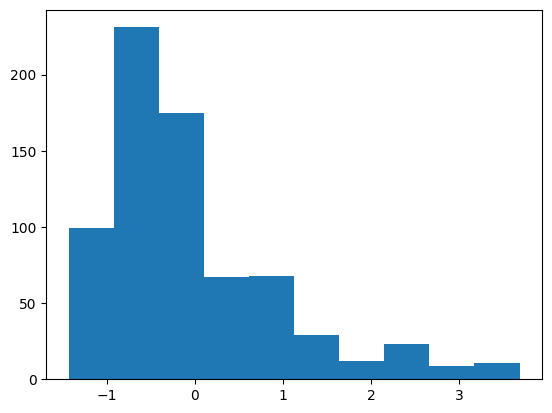

In [15]:
df = df[df['area'] > 600]

df['area'] = np.log(df['area'])

mean = df['area'].mean()
std_dev = df['area'].std()

print(f'Mean: {mean} , std_dev: {std_dev}')

df['area'] = (df['area']-mean)/std_dev
plt.hist(df['area'], bins=10)
plt.show()

## Width Road

Mean: 2.250238284146862 , std_dev: 0.6616294390712966


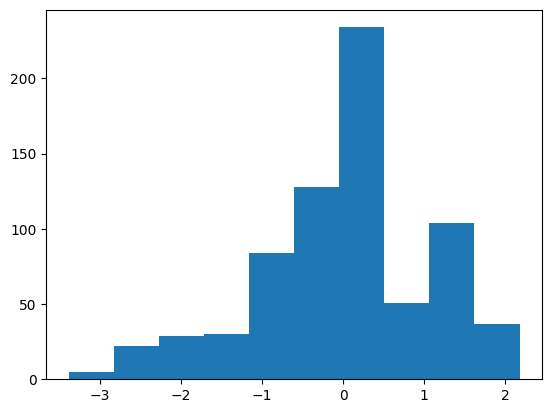

In [16]:
width_log = np.log(df['width_road']+0.01)

mean = width_log.mean()
std_dev = width_log.std()

print(f'Mean: {mean} , std_dev: {std_dev}')

width_norm = (width_log - mean)/std_dev

df['width_road'] = width_norm
plt.hist(width_norm, bins=10)
plt.show()

## Open Sides x Width

Mean: 2.8180932169586836 , std_dev: 0.7954702674245552


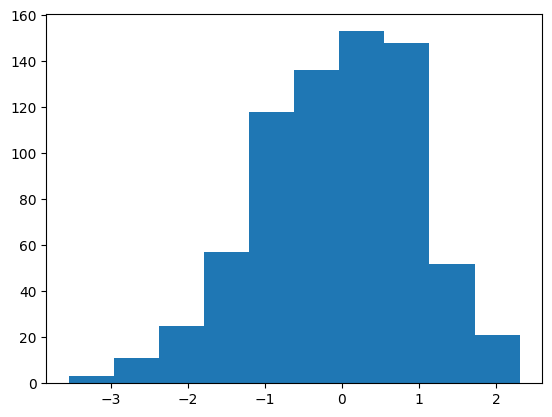

In [17]:
df['width_open'] = np.log(df['width_open'])

mean = df['width_open'].mean()
std_dev = df['width_open'].std()

print(f'Mean: {mean} , std_dev: {std_dev}')

df['width_open'] = (df['width_open']-mean)/std_dev
plt.hist(df['width_open'], bins=10)
plt.show()

## Additional Features

Mean: -1.9187939331933004 , std_dev: 0.9169052779150308
Mean: -1.1204044099254058 , std_dev: 0.6956414037035519


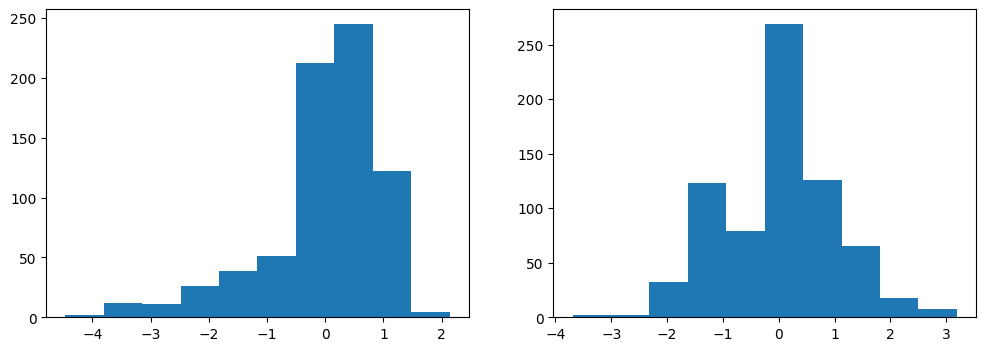

In [18]:
fig , (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))

df['floor_by_area'] = np.log(df['floor_by_area'])

mean = df['floor_by_area'].mean()
std_dev = df['floor_by_area'].std()

print(f'Mean: {mean} , std_dev: {std_dev}')

df['floor_by_area'] = (df['floor_by_area']-mean)/std_dev
ax1.hist(df['floor_by_area'], bins=10)

df['floor_by_width'] = np.log(df['floor_by_width'])

mean = df['floor_by_width'].mean()
std_dev = df['floor_by_width'].std()

print(f'Mean: {mean} , std_dev: {std_dev}')

df['floor_by_width'] = (df['floor_by_width']-mean)/std_dev
ax2.hist(df['floor_by_width'], bins=10)
plt.show()

# Show Relationships

Text(0.5, 1.0, 'Floor/Width')

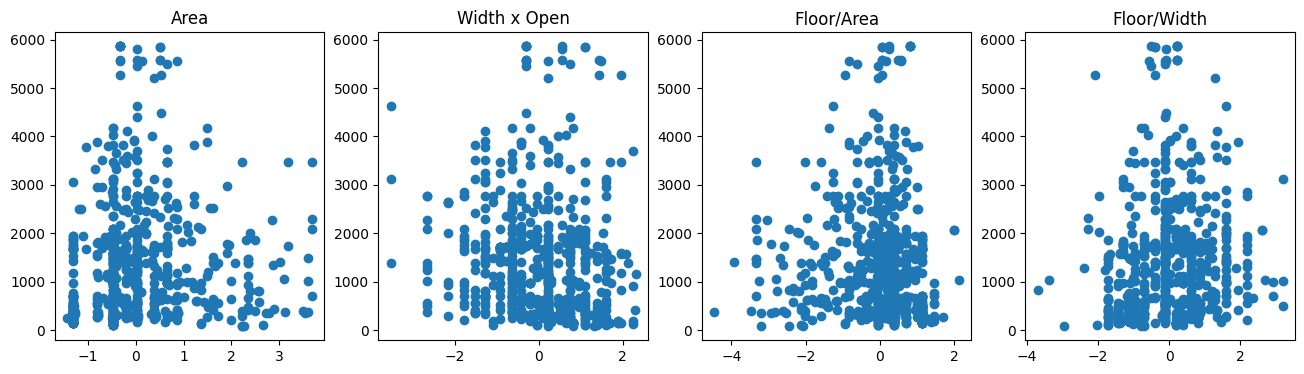

In [19]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,4))
ax1.scatter(df['area'], df['price_per_sqft'])
ax1.set_title('Area')
ax2.scatter(df['width_open'], df['price_per_sqft'])
ax2.set_title('Width x Open')
ax3.scatter(df['floor_by_area'], df['price_per_sqft'])
ax3.set_title('Floor/Area')
ax4.scatter(df['floor_by_width'], df['price_per_sqft'])
ax4.set_title('Floor/Width')

# Location Dummies

In [20]:
location_dummy = df['location'].str.get_dummies(sep=', ').astype(float)
# location_sums = location_dummy.sum()

# location_dummy.to_csv('locations.csv', index=False)
df = pd.concat([df, location_dummy], axis=1)

df = df.drop(['location'], axis=1)
df.shape

(724, 192)

In [21]:
df.head()

,boundary,construction,floor,open_sides,price_per_sqft,garden_park,main_road,pool,width_road,area,...,Subhayan Park,Taltala,Tangra,Thakurpukur,Tollygunge,Tollygunge Phari,Tribeni,Uchhepota,Uttarpara,Uttarpara Kotrung
0,1,1,5.0,2.0,1597,1,1,0,1.740086,-0.462279,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,4.0,1.0,1681,1,1,0,-0.256258,0.652241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,3.0,2.0,194,0,1,0,1.464623,-1.305381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,4.0,1.0,5574,0,1,0,0.476823,-0.322775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,3.0,4.0,565,1,1,0,-1.735561,-0.274780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Training Models

In [22]:
def compare_pred(ax, model, X, y, to_display=20) :
    y_hat = model.predict(X).flatten()
    pred = pd.DataFrame({'Prediction': y_hat})
    
    comparison = pd.concat([pred, y], axis=1)

    X = X[:to_display]
    pred = pred[:to_display]
    y = y[:to_display]

    ax.scatter(range(len(X)), pred, color='blue', label='Predictions')
    ax.scatter(range(len(X)), y, color='orange', label='Actual')

    ax.set_ylabel('Values')
    ax.set_xlabel('Index')
    ax.set_title('Comparison of Prediction and Actual')
    ax.grid(True)
    ax.legend()
    
    # comparison.plot(marker='o')

    return comparison

In [23]:
X_train = df.drop(['price_per_sqft'], axis=1)
y_train = df['price_per_sqft']

X_train.shape, y_train.shape

((724, 191), (724,))

## Linear Regression

Iteration 3000, Loss: 586884.9918885954
Iteration 6000, Loss: 567595.2530318077
Iteration 9000, Loss: 564095.7714626824
Iteration 12000, Loss: 560854.6640715117
Iteration 15000, Loss: 560188.0432041517
Iteration 18000, Loss: 559672.7993357757
Iteration 21000, Loss: 559201.3649168969
Iteration 24000, Loss: 559029.072428661
Iteration 27000, Loss: 558910.0057644347
Iteration 30000, Loss: 559466.4715477764


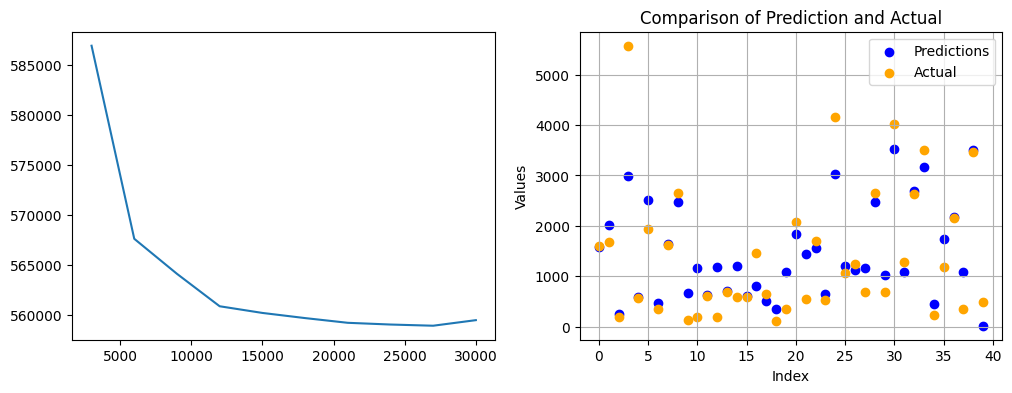

In [24]:
iterations = 30000  # Number of iterations
model = SGDRegressor(alpha=0.000000001, max_iter=iterations, warm_start = True)

# Training loop to record loss every 100 iterations
history = {'iteration': [], 'loss': []}
for i in range(1, iterations + 1):
    model.partial_fit(X_train, y_train)
    if i % (iterations//10) == 0:
        loss = np.mean((model.predict(X_train) - y_train) ** 2)
        history['iteration'].append(i)
        history['loss'].append(loss)
        print(f"Iteration {i}, Loss: {loss}")

# model.fit(X_train, y_train)

# Accessing the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))

ax1.plot(history['iteration'], history['loss'])
                               
comparison = compare_pred(ax2, model, X_train, y_train, 40)

plt.show()


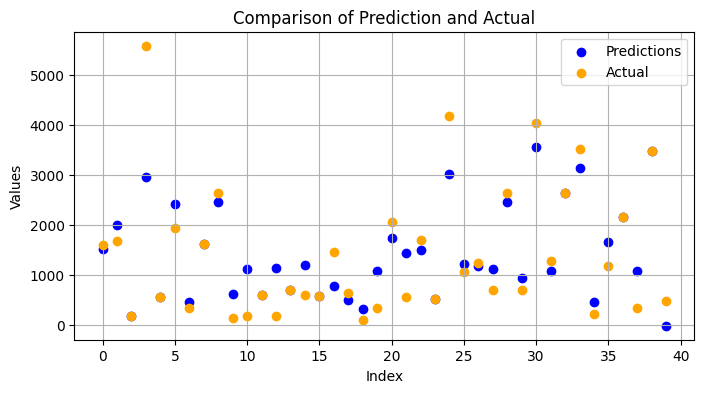

In [25]:
model = LinearRegression()
model.fit(X_train, y_train)

fig, ax = plt.subplots(1,1, figsize=(8, 4))
                               
comparison = compare_pred(ax, model, X_train, y_train, 40)
plt.show()

## Neural Network

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


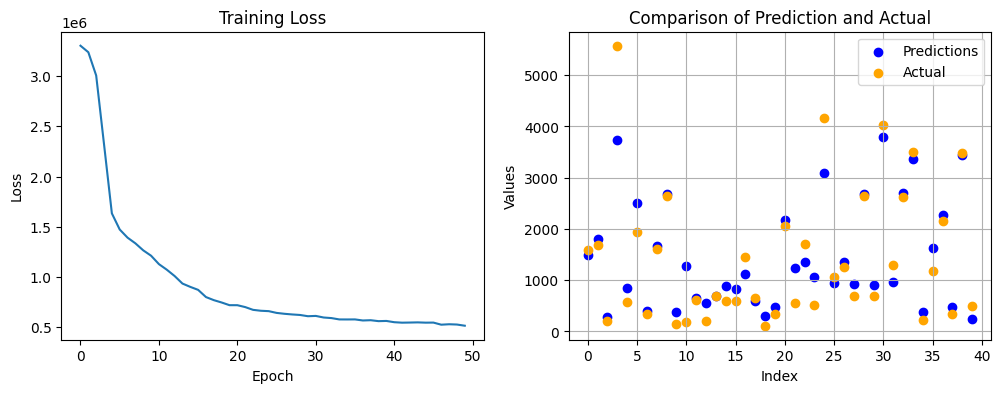

Cost: 513570.8125
Slope: 0.020961463
Intercept: 0.16541332


In [26]:
# Define the linear regression model using TensorFlow
model = Sequential([
    Dense(units=288, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1, activation='linear')
])

# Compile the model
model.compile(optimizer=Adam(), loss=MeanSquaredError(), metrics=['mae'])

# X_tensor = tf.constant(X_train.values, dtype=tf.float32)
# y_tensor = tf.constant(y_train.values, dtype=tf.float32)

# Train the model
history = model.fit(X_train, y_train, epochs=50, verbose=0)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))

# Plot the training history
ax1.plot(history.history['loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')

comparison = compare_pred(ax2, model, X_train, y_train, 40)
plt.show()

print('Cost:', history.history['loss'][-1])

# Get the trained weights (slope and intercept)
slope, intercept = model.layers[0].get_weights()
print("Slope:", slope[0, 0])
print("Intercept:", intercept[0])

# Get Predictions

In [27]:
def get_predictions(data: dict) :
    
    X = np.zeros(len(X_train.columns))
    
    X[0] = data.get('boundary', 0)
    X[1] = data.get('construction', 0)
    X[2] = data.get('floor', 2)
    X[3] = data.get('open_sides', 2)
    X[4] = data.get('garden_park', 0)
    X[5] = data.get('main_road', 0)
    X[6] = data.get('pool', 0)
    X[7] = data.get('width_road', 10)
    X[8] = data.get('area', 1440)
    X[9] = data.get('new_property', 1)
    
    X[10] = X[7] * X[3] # width_open
    X[11] = X[2] / X[8] # floor_by_area
    X[12] = X[2] / X[7] # floor_by_width
    
    area_mean, area_std = 7.652456222450403, 0.8221394216377748
    width_mean, width_std = 2.250238284146862 , 0.6616294390712966
    width_open_mean, width_open_std = 2.8180932169586836 , 0.7954702674245552
    floor_by_area_mean, floor_by_area_std = -1.9187939331933004 , 0.9169052779150308
    floor_by_width_mean, floor_by_width_std =  -1.1204044099254058 , 0.6956414037035519
    
    X[8]  = (np.log(X[8] ) - area_mean) / area_std
    X[7]  = (np.log(X[7] ) - width_mean) / width_std
    X[10] = (np.log(X[10]) - width_open_mean) / width_open_std
    X[11] = (np.log(X[11]) - floor_by_area_mean) / floor_by_area_std
    X[12] = (np.log(X[12]) - floor_by_width_mean) / floor_by_width_std

    ## Location

    if 'location' in data :
        for location in data['location'] :
            loc_idx = np.where(X_train.columns == location)[0][0]
            X[loc_idx] = 1
    else :
        loc_idx = np.where(X_train.columns == 'Rajarhat')[0][0]
        X[loc_idx] = 1

    print(np.sum(X[13:]))

    X_reshape = X.reshape(1, -1)

    return model.predict(X_reshape)[0]

In [28]:
data = {
    'area' : 10000,
    'location' : ['Boral']
}


get_predictions(data) * data.get('area', 1440)

1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([10128191.], dtype=float32)

In [29]:
import json

columns = {
    'data_columns' : [col for col in X_train.columns]
}

with open("columns.json", 'w') as f:
    f.write(json.dumps(columns))

locations = {
    'locations' : [col for col in X_train.columns[13:]]
}

with open("locations.json", 'w') as f:
    f.write(json.dumps(locations))